In [1]:
%load_ext lab_black

In [2]:
import torch
from torch import nn
import pyro
from pyro.infer import SVI, Trace_ELBO
import pyro.distributions as dist
import torch.distributions.constraints as constraints
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [21]:
# 产生模拟数据
p = 3
beta = torch.tensor([1.0, -1.0, 2.0, -1]).view(-1, 1)
N = 10000
X = torch.distributions.Normal(0.0, 2.0).sample([N, p])
X = torch.cat([torch.ones([N, 1]), X], axis=1)
epi = torch.distributions.Normal(0.0, 1.0).sample([N, 1])
Y = X.mm(beta) + epi

dataset = TensorDataset(X, Y)
batch_size = 200
loader = DataLoader(dataset, batch_size=batch_size)

In [79]:
class ELBO_B(nn.Module):
    def __init__(self):
        super(ELBO_B, self).__init__()
        self.mu = nn.Parameter(torch.rand([p + 1, 1]))
        self.rho = nn.Parameter(torch.rand([p + 1, 1]))

    def forward(self, x, y):
        sigma = torch.log(1 + torch.exp(self.rho))
        mu = self.mu
        L = 1
        # 产生L个z
        normal = torch.distributions.Normal(
            torch.zeros_like(mu), torch.ones_like(sigma)
        )
        epislon = normal.sample()
        beta = mu + sigma * epislon

        M = len(x)
        L_A = 0
        p = torch.distributions.Normal(x.mm(beta), 0.1)
        D_KL = -1 / 2 * (torch.log(sigma ** 2) + 1 - mu ** 2 - sigma ** 2).sum()
        for l in range(L):

            L_A = L_A + (p.log_prob(y).sum() - D_KL)
        L_M = L_A / L
        return L_M * M / N

In [80]:
model = ELBO_B()
model(x, y).shape

torch.Size([])

In [81]:
model = ELBO_B()
iters = 100
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
loss_values = torch.zeros([iters])
for i in range(iters):
    for data in loader:
        x, y = data
        optimizer.zero_grad()
        loss = -model(x, y)
        loss.backward()
        optimizer.step()
        loss_values[i] = loss

In [83]:
print("True beta")
print(beta)
model.state_dict()["mu"]

True beta
tensor([[ 1.],
        [-1.],
        [ 2.],
        [-1.]])


tensor([[ 0.9584],
        [-0.9993],
        [ 2.0094],
        [-1.0196]])

In [58]:
torch.log(1 + torch.exp(model.rho))

tensor([[0.0072],
        [0.0057],
        [0.0068],
        [0.0048]], grad_fn=<LogBackward>)

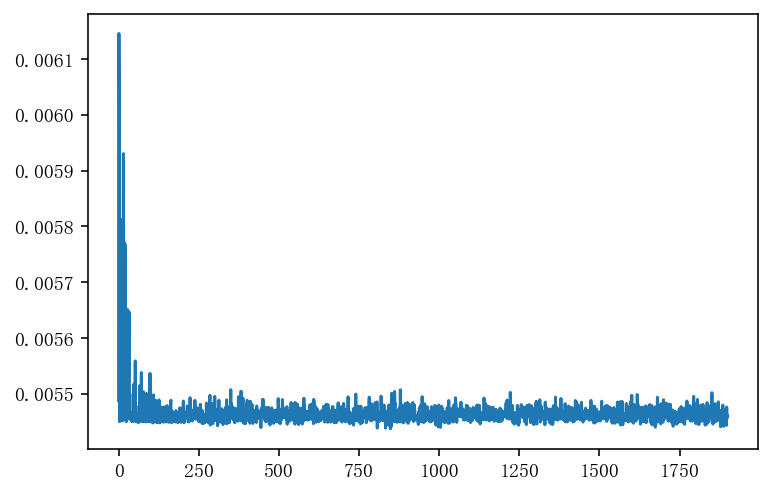

In [11]:
plt.plot(loss_values.detach().numpy()[100:] / N)

In [9]:
torch.rand([p + 1, 1])

tensor([[0.5567],
        [0.4526],
        [0.3597],
        [0.2629]])

In [96]:
class ELBO_B(nn.Module):
    def __init__(self):
        super(ELBO_B, self).__init__()
        self.mu = nn.Parameter(torch.rand([p + 1, 1]))
        self.rho = nn.Parameter(torch.rand([p + 1, 1]))

    def forward(self, x, y):
        sigma = torch.log(1 + torch.exp(self.rho))
        mu = self.mu
        L = 10
        # 产生L个z
        normal = torch.distributions.Normal(
            torch.zeros_like(mu), torch.ones_like(sigma)
        )
        epislon = normal.sample()
        beta = mu + sigma * epislon
        p = torch.distributions.Normal(x.mm(beta), 0.1)
        D_KL = -1 / 2 * (torch.log(sigma ** 2) + 1 - mu ** 2 - sigma ** 2).sum()
        # 计算ELBO(φ；x(i))
        L_B = -D_KL + p.log_prob(y).sum()
        # 计算ELBO
        #L_M = L_B.mean()
        return L_B

In [97]:
model = ELBO_B()
model(x, y).shape

torch.Size([])

In [98]:
model = ELBO_B()
iters = 100
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
loss_values = torch.zeros([iters])
for i in range(iters):
    for data in loader:
        x, y = data
        optimizer.zero_grad()
        loss = -model(x, y)
        loss.backward()
        optimizer.step()
        loss_values[i] = loss

print("True beta")
print(beta)
model.state_dict()["mu"]

True beta
tensor([[ 1.],
        [-1.],
        [ 2.],
        [-1.]])


tensor([[ 0.9501],
        [-1.0116],
        [ 2.0077],
        [-1.0240]])